# Example: Escanciano–Lobato Test with Volatility Modeling

This notebook demonstrates the **Escanciano–Lobato (EL) serial correlation test**, which is robust to heteroskedasticity and especially useful in situations where volatility clustering is expected. It shows how to apply the test alongside GARCH modeling in practice.

**Workflow Overview:**
1. Load and preprocess monthly simple returns of Intel stock from **January 1973 to December 2008** (from `m-intc7308.txt`).
2. Apply the EL test to assess serial correlation in the returns.
3. Fit a GARCH(1,1) model to the log-return series.
4. Re-apply the EL test on standardized residuals to verify mean and variance adequacy.
5. Generate 1- to 5-step-ahead volatility forecasts from the December 2008 origin.

**Purpose:**
This notebook serves as an illustrative use case for the `escanciano_lobato` function implemented in the `rust_timeseries` library. It demonstrates how the test integrates into a typical volatility modeling workflow.

**Exercise Context:**
This example follows **Exercise 3.5** from *Analysis of Financial Time Series* (3rd ed., Chapter 3) by **Ruey S. Tsay**, which asks for volatility forecasts of Intel stock log returns and to assess model adequacy.

**Dataset Details:**
- **Source:** Faculty website of Ruey Tsay (m-intc7308.txt)
- **Frequency:** Monthly
- **Variable:** Monthly simple returns of Intel stock (to be transformed into log returns)

## Data & Setup

**Dataset**
- **Asset:** Intel Corporation (INTC)
- **Variable:** Monthly *simple* returns (we’ll transform to log returns)
- **Span:** January 1973 – December 2008 (inclusive)
- **Frequency:** Monthly
- **Source file:** `m-intc7308.txt` (from Ruey S. Tsay’s teaching materials)

**Preprocessing summary**
1. Parse the `date` column as calendar month-end timestamps.  
2. Validate there are no missing values and no impossible returns ($\le −100\%$).  
3. Work with **log returns** $\log(1 + r_t)$ for modeling.

**Why log returns?**  
Log returns are additively aggregable across periods and tame multiplicative effects; for small $r_t$, log and simple returns are numerically close, but logs are more convenient analytically.

**Indexing**  
We analyze the series with a **DatetimeIndex** so plots, diagnostics, and forecasts align to calendar dates.

**Reproducibility**  
Package versions and environment details are listed at the end so results are reproducible.

Load Intel monthly returns (1973–2008):

In [288]:
import pandas as pd

url: str = 'https://faculty.chicagobooth.edu/-/media/faculty/ruey-s-tsay/teaching/fts3/m-intc7308.txt'
data: pd.DataFrame = pd.read_table(url, sep=r'\s+')

# Preview of raw input (simple returns).
data.head()

,date,rtn
0,19730131,0.010050
1,19730228,-0.139303
2,19730330,0.069364
3,19730430,0.086486
4,19730531,-0.104478


Verify lack of NaN/Null values in the data:

In [289]:
data['date'].isnull().any()

np.False_

Parse the date column as calendar month-end timestamps:

In [290]:
data['date'] = pd.to_datetime(data['date'], format='%Y%m%d')
data.set_index(data['date'], inplace=True)
data.drop('date', inplace=True, axis=1)

# After parsing dates and setting them to be the index.
data.head()

,rtn
date,
1973-01-31,0.010050
1973-02-28,-0.139303
1973-03-30,0.069364
1973-04-30,0.086486
1973-05-31,-0.104478


Confirm there are no missing values were introduced by the transformation, check numeric dtype, and verify no values $\le −100\%$ (so $\log⁡(1+rt)$ is defined):

In [291]:
returns: pd.Series = data['rtn']
nulls: bool = returns.isnull().any()
ret_type = returns.dtype
less_than_one: bool = returns.loc[returns <= - 1].any()
print(f"Nulls: {nulls}, type: {ret_type}, less than 1: {less_than_one}")

Nulls: False, type: float64, less than 1: False


We compute $\log⁡(1+rt)$. Because we verified $rtn > −1$, $1+rtn$ is positive for all observations, so the transform is well-defined:

In [292]:
import numpy as np

data['log_rtn'] = np.log(data['rtn'] + 1)

# After log-return transform.
data.head()

,rtn,log_rtn
date,,
1973-01-31,0.010050,0.010000
1973-02-28,-0.139303,-0.150013
1973-03-30,0.069364,0.067064
1973-04-30,0.086486,0.082949
1973-05-31,-0.104478,-0.110348


Initial diagnostics: time plot, ACF, and PACF:

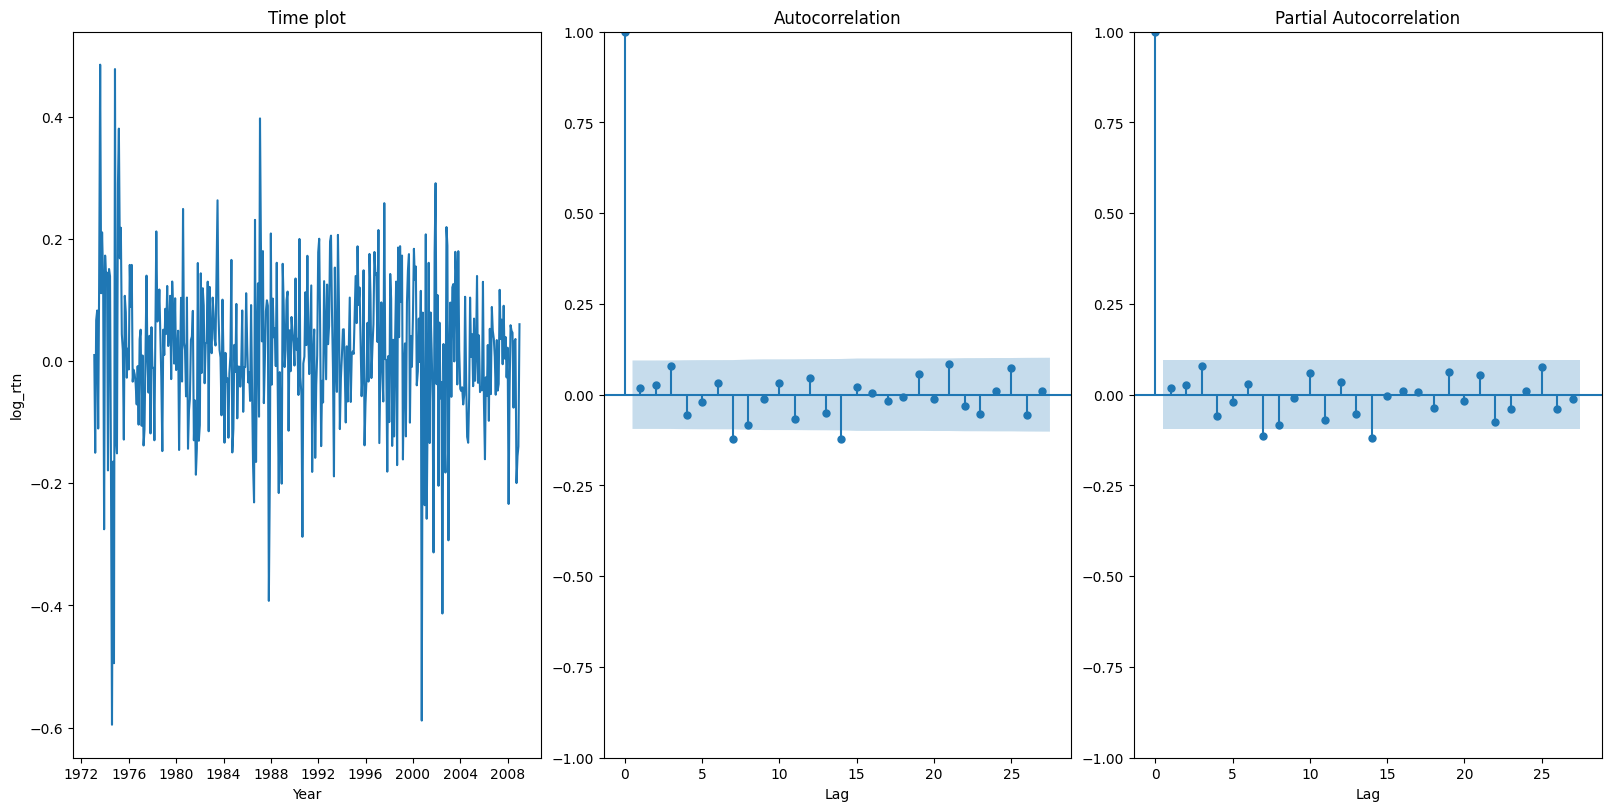

In [293]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_ts_pacf_acf(data: pd.Series):
    fig, ax = plt.subplots(1, 3, figsize=(16, 8), layout='constrained')
    ax[0].set_title('Time plot')
    ax[0].set_xlabel('Year')
    ax[0].set_ylabel(data.name)
    ax[0].plot(data.index, data);
    for i in range (1, 3):
        ax[i].set_xlabel('Lag')
    plot_acf(data, ax=ax[1]);
    plot_pacf(data, ax=ax[2]);
plot_ts_pacf_acf(data['log_rtn'])

We see clear volatility clustering in the time plot (e.g., 1973–1976 vs. 1980–1984).
The ACF/PACF of returns show no strong ARMA signature. We proceed under a zero-mean specification and will test stationarity formally.

## Stationarity Checks

We assess stationarity using **Phillips–Perron (PP)** and **KPSS** in tandem.

**Why both?**  
The PP test is chosen over ADF because we suspect **heteroskedasticity**—visible as volatility clustering in the time plot—and PP is robust to such effects.  
The KPSS test, also robust to heteroskedasticity, complements PP by reversing the null hypothesis:

- **PP test**: $H_0$ = unit root (nonstationary); reject $H_0$ → evidence of stationarity.
- **KPSS test**: $H_0$ = (trend-)stationary; fail to reject $H_0$ → evidence consistent with stationarity.

Using both, with complementary nulls, makes the conclusion more robust: agreement between PP and KPSS provides stronger evidence of stationarity.
In our data, PP yields $p \approx 0.00$ and KPSS yields $p \approx 0.10$, consistent with stationarity of monthly log returns at the 5% level.

In [294]:
import warnings
from arch.unitroot import PhillipsPerron
from statsmodels.tsa.stattools import kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning

print(f"The p value for the PP test is: {PhillipsPerron(data['log_rtn'], trend='n').pvalue}")
with warnings.catch_warnings():
    warnings.simplefilter("ignore", InterpolationWarning)   
    print(f"The p value for the KPSS test is: {kpss(data['log_rtn'])[1]}")

The p value for the PP test is: 0.0
The p value for the KPSS test is: 0.1


Note. The KPSS statistic lies outside the tabulated range used by statsmodels, so the p‑value is reported as a bound (e.g., $p < 0.01$ or $p > 0.10$). We rely on the statistic and the reported critical values to make the decision; the conclusion is unaffected by using a bound. Since the null for the Phillips-Perron test is the existence of a unit root and we got a very significant p value (and the opposite for KPSS), we can comfortably believe that our series is stationary at the 5% significance level.

### Seasonal Differencing Attempt

Although the PP and KPSS tests suggest that the log return series is stationary, the time plot hinted at possible **seasonal structure**.  
To check this, we difference the series at lag 7 (approximately half a year for monthly data) and re-examine the autocorrelation structure.

In [295]:
data['seas_diff_log_rtn'] = data['log_rtn'].diff(7)

# After seasonal difference (lag 7).
data.head(15)

,rtn,log_rtn,seas_diff_log_rtn
date,,,
1973-01-31,0.010050,0.010000,NaN
1973-02-28,-0.139303,-0.150013,NaN
1973-03-30,0.069364,0.067064,NaN
1973-04-30,0.086486,0.082949,NaN
1973-05-31,-0.104478,-0.110348,NaN
1973-06-29,0.133333,0.125163,NaN
1973-07-31,0.625000,0.485508,NaN
1973-08-31,0.117647,0.111226,0.101226
1973-09-28,0.234818,0.210924,0.360936


Now we plot our ACF and PACF:

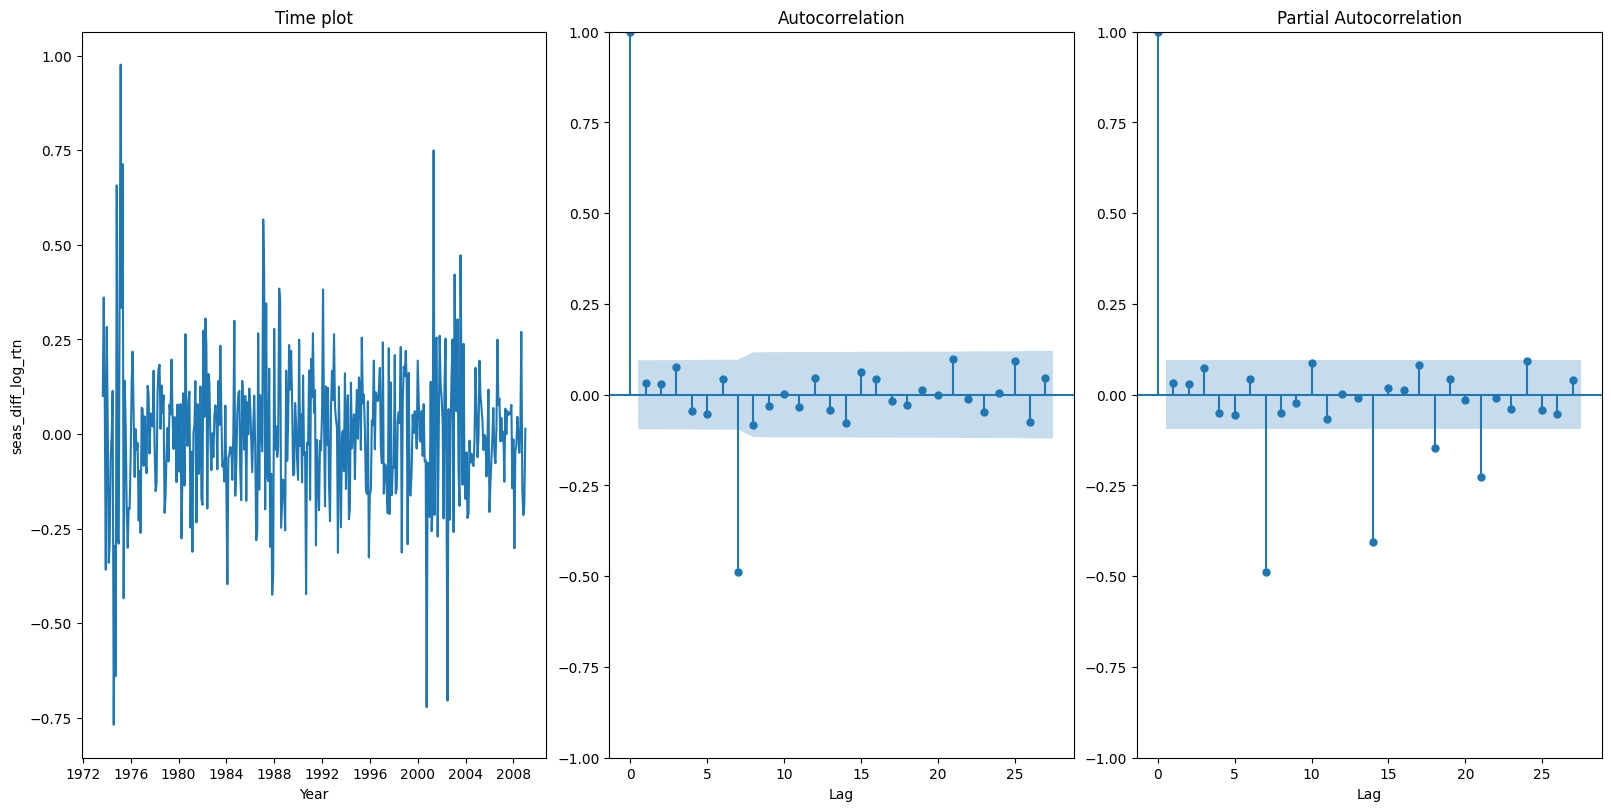

In [296]:
plot_ts_pacf_acf(data['seas_diff_log_rtn'][7:])

As you can see, differencing did not help. There are massive negative lag spikes that imply over-differencing. We therefore turn to a heteroskedasticity-robust serial correlation test (instead of the usual Ljung-Box) developed by Escanciano and Lobato in their 2009 paper:

In [297]:
from rust_timeseries.statistical_tests import EscancianoLobato
'%.6f'%EscancianoLobato(data['log_rtn']).pvalue

'0.770087'

As we can see, our p-value is not at all significant at the 5% level which means we can deduce no serial correlation. 

## Volatility Modeling

With no evidence of serial correlation in the mean of log returns, we now turn to modeling **time-varying volatility**.  
The squared return plot and the ACF/PACF of squared residuals indicate strong **ARCH/GARCH effects**, which is typical in financial return series.  

Our approach is:

1. **Demean the series** to focus on volatility dynamics rather than mean structure.  
2. **Inspect squared residuals** to confirm the presence of volatility clustering.  
3. **Apply the Escanciano–Lobato test** on squared residuals to formally check for dependence in second moments.  
4. **Fit a GARCH(1,1) model** with standard Gaussian innovations, the standard benchmark for volatility modeling.  
5. **Diagnose standardized residuals** to evaluate model adequacy.  
6. **Generate volatility forecasts** (1- and 5-step ahead) to complete the exercise.  

This workflow lets us verify that the GARCH(1,1) specification captures the volatility dynamics of Intel’s monthly log returns. We start by calculating the residuals:

In [298]:
data['residuals'] = data['log_rtn'] - data['log_rtn'].mean()
data['squared_residuals'] = data['residuals']**2

# Residuals and squared residuals (for ARCH checks).
data.head()

,rtn,log_rtn,seas_diff_log_rtn,residuals,squared_residuals
date,,,,,
1973-01-31,0.010050,0.010000,NaN,-0.003882,0.000015
1973-02-28,-0.139303,-0.150013,NaN,-0.163895,0.026861
1973-03-30,0.069364,0.067064,NaN,0.053182,0.002828
1973-04-30,0.086486,0.082949,NaN,0.069067,0.004770
1973-05-31,-0.104478,-0.110348,NaN,-0.124230,0.015433


Now we can plot our ACF/PACFs:

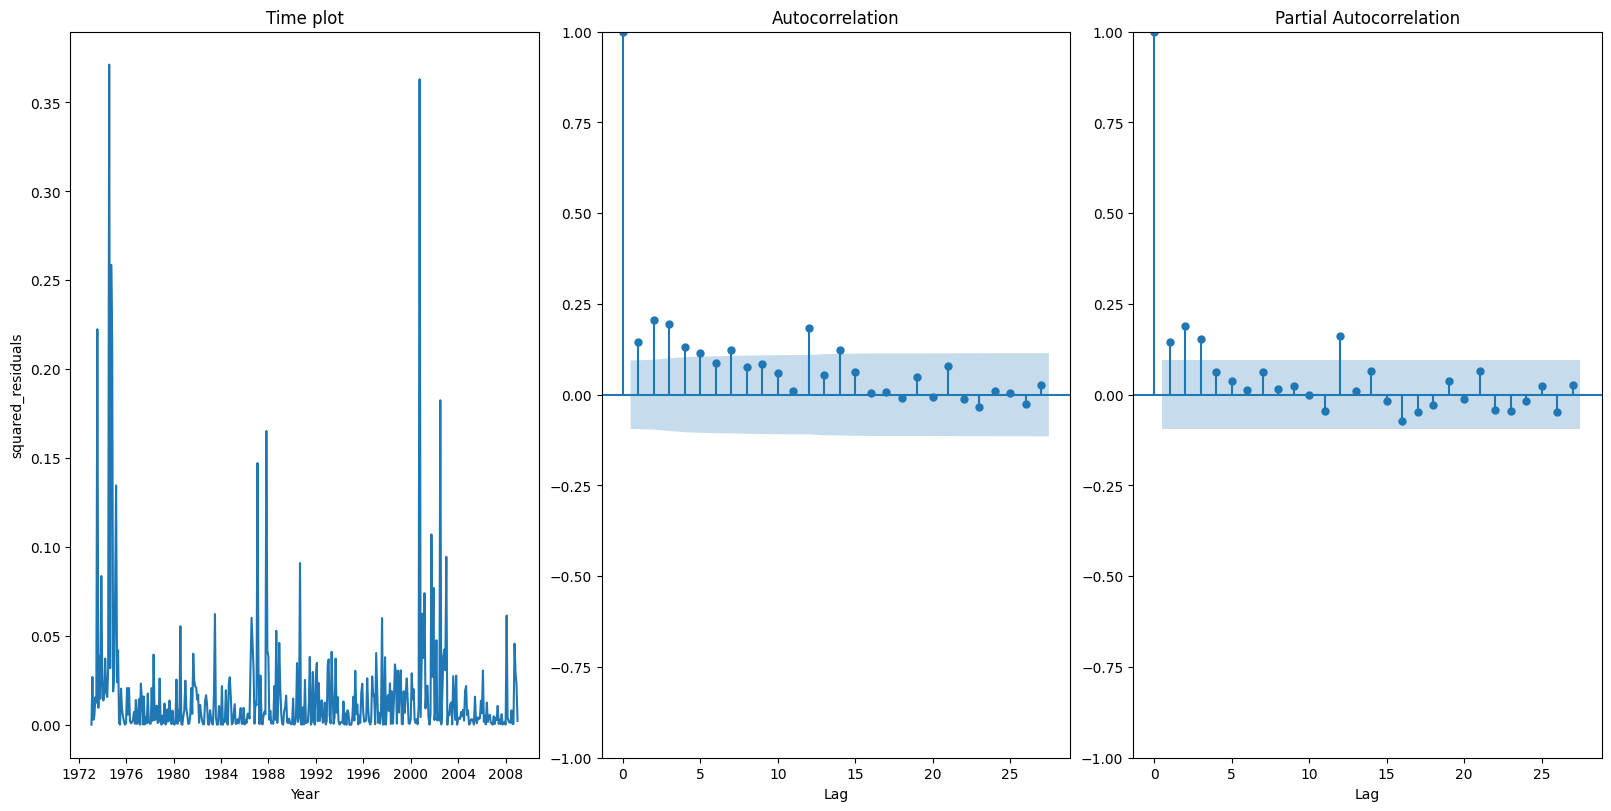

In [299]:
plot_ts_pacf_acf(data['squared_residuals'])

Seems like we have some ARCH and GARCH effects in the first 4 lags. Let's start by running the EL test on our squared series:

In [300]:
el = EscancianoLobato(data['squared_residuals'])
print (f"The p-value is: {el.pvalue:.6f}")
print (f"The number of lags tested is: {el.p_tilde}")

The p-value is: 0.092370
The number of lags tested is: 1


Seems like we have 1 lag significance at the 10% level, let's try to fit a GARCH(1,1) model with standard Gaussian innovations:

In [301]:
from arch.univariate import arch_model
from arch.univariate.base import ARCHModel, ARCHModelResult

# Rescaled the column to improve numerical stability.
data['scaled_residuals'] = data['residuals']*10
garch: ARCHModel = arch_model(data['scaled_residuals'], mean='Zero', vol='GARCH', p=1, q=1, dist='normal')
fit_garch: ARCHModelResult = garch.fit(disp='off')
fit_garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:       scaled_residuals   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.002
Vol Model:                      GARCH   Log-Likelihood:               -692.428
Distribution:                  Normal   AIC:                           1390.86
Method:            Maximum Likelihood   BIC:                           1403.06
                                        No. Observations:                  432
Date:                Sat, Aug 16 2025   Df Residuals:                      432
Time:                        15:15:12   Df Model:                            0
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.0777  3.223e-02      2.410  1.596e-02 [1.450e-02,  0.141]
alpha[1]       0.0686  2.311e-02      2.970  2.973e-03 [2.335e-02,  0.114]
beta[1]        0.8768  3.146e-02     27.867 6.713e-171   [  0.815,  0.938]
==========================================================================

Covariance estimator: robust
"""

We can see that all parameter values are statistically significant at 5%. Now we check the quality of fit using the standardized residuals. First we look at the ACF/PACFs:

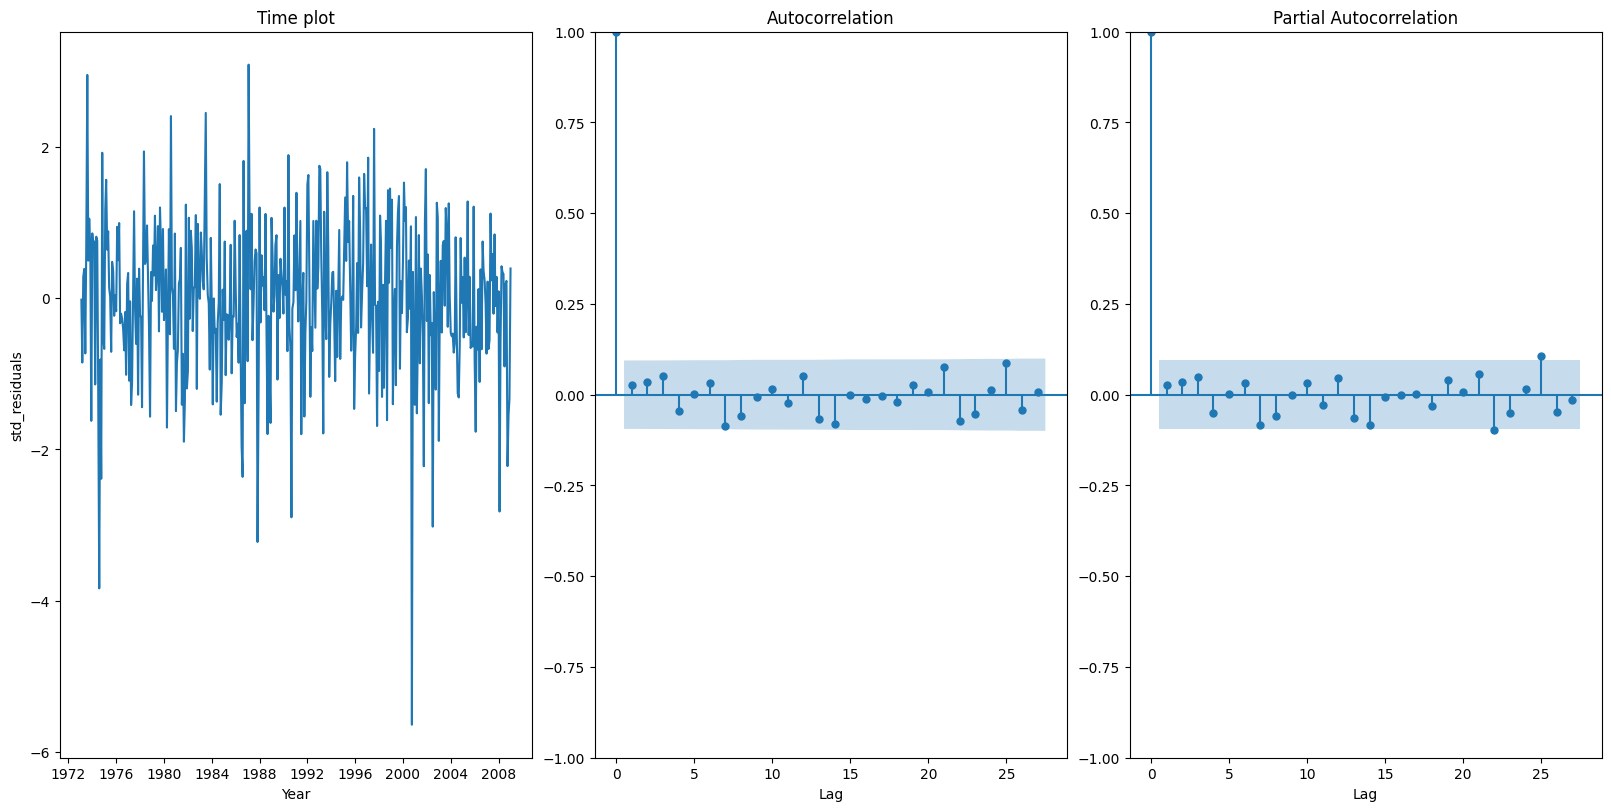

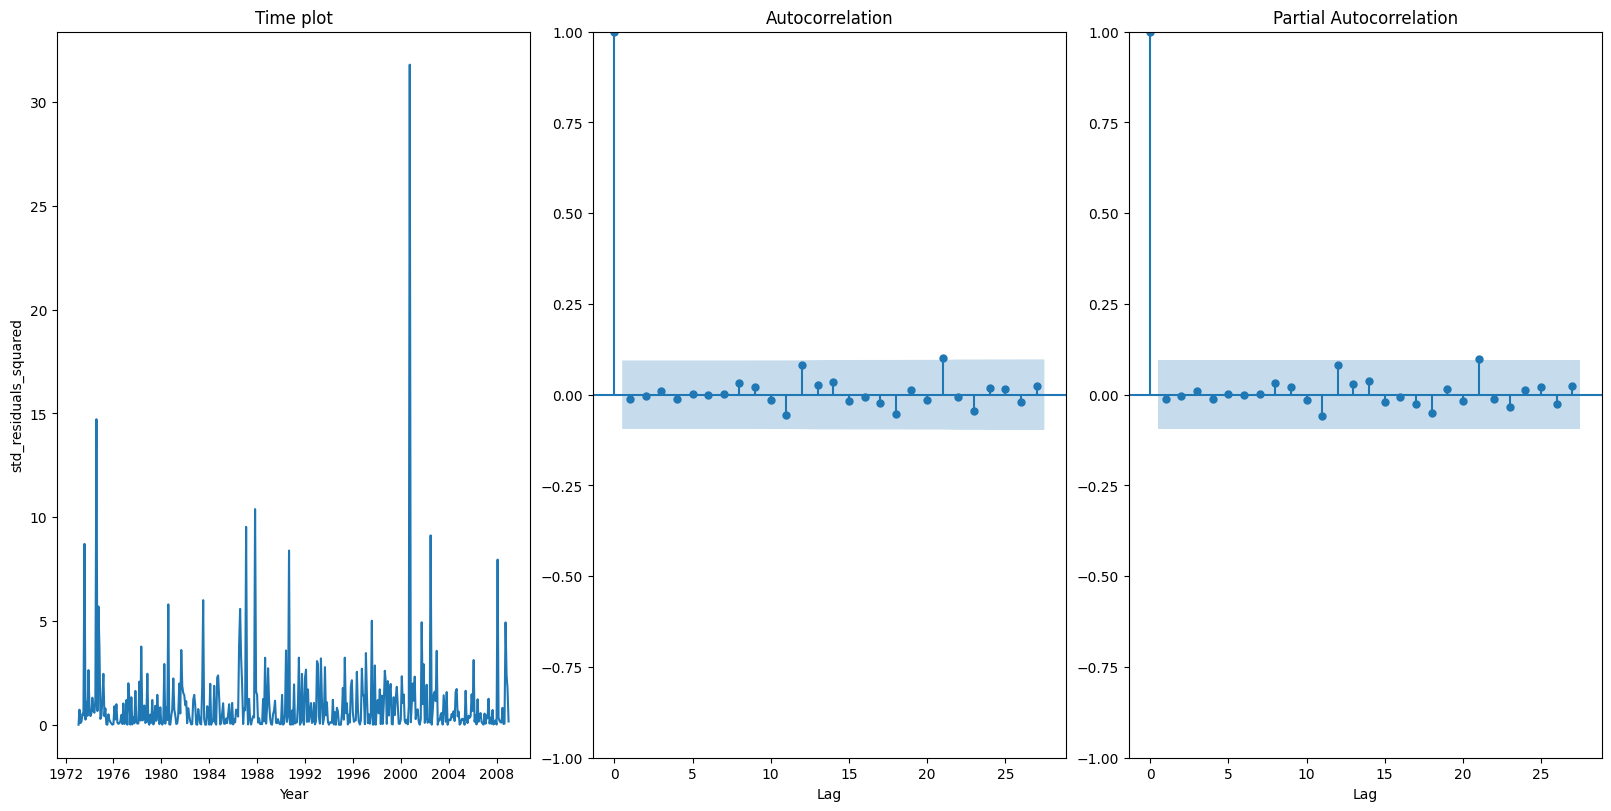

In [302]:
data['std_residuals'] = data['scaled_residuals']/fit_garch.conditional_volatility
data['std_residuals_squared'] = data['std_residuals']**2
plot_ts_pacf_acf(data['std_residuals'])
plot_ts_pacf_acf(data['std_residuals_squared'])

Visual diagnostics show no evidence of serial correlation. Now we test:

In [303]:
el_std = EscancianoLobato(data['std_residuals'])
print (f"The p-value for the standardized residuals is: {el_std.pvalue:.6f}")
print (f"The number of lags tested for the standardized residuals is: {el_std.p_tilde}")
el_std_squared = EscancianoLobato(data['std_residuals_squared'])
print (f"The p-value for the squared standardized residuals is: {el_std_squared.pvalue:.6f}")
print (f"The number of lags tested for the squared standardized residuals is: {el_std_squared.p_tilde}")

The p-value for the standardized residuals is: 0.551061
The number of lags tested for the standardized residuals is: 1
The p-value for the squared standardized residuals is: 0.610649
The number of lags tested for the squared standardized residuals is: 1


Both p-values are insignificant which support our visual reasoning. Now let us look at the QQ plot of the standardized residuals to check if tail behavior is accurate:

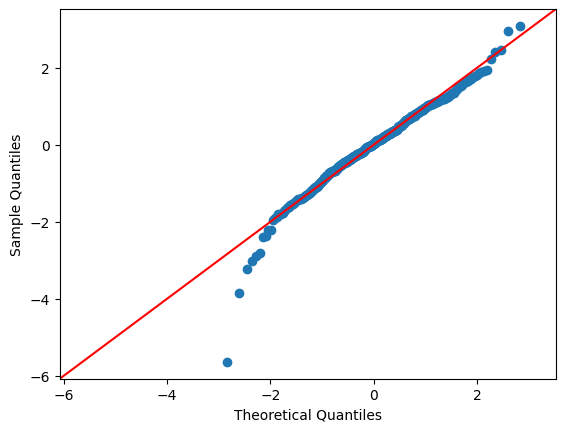

In [304]:
import statsmodels.api as sm
qq_plt = sm.qqplot(data['std_residuals'], line='45')

The QQ plot suggests that our pick of the normal distribution for the innovations fits our data fairly well. There is some indication of slightly heavier tails by the S-shaped taper at the edges but it is fairly small so we will keep our model as is. Finally we forecast 1 and 5 step ahead forecasts from the origin of December 2008:

In [305]:
from arch.univariate.base import ARCHModelForecast
from datetime import datetime
five_step_forecast: ARCHModelForecast = fit_garch.forecast(horizon=5)
h_1 = five_step_forecast.variance['h.1'].iloc[-1]/100.0
h_5 = five_step_forecast.variance['h.5'].iloc[-1]/100.0
print(f"The one step ahead forecast is: {h_1:.6f}")
print(f"The five step ahead forecast is: {h_5:.6f}")

The one step ahead forecast is: 0.013245
The five step ahead forecast is: 0.013445


## Conclusion & Reproducibility

### Key Takeaways
- **Stationarity**: The Phillips–Perron test rejected the unit root null, while the KPSS test did not reject stationarity. Together, these provide consistent evidence that Intel’s monthly log returns (1973–2008) are stationary.  
- **Serial correlation**: The Escanciano–Lobato (EL) test found no significant serial correlation in raw returns, supporting a zero-mean specification.  
- **Volatility structure**: EL tests on squared returns indicated ARCH/GARCH effects. A GARCH(1,1) with Gaussian innovations was fit, with all parameters statistically significant.  
- **Diagnostics**: Standardized residuals showed no remaining serial correlation or volatility clustering; QQ plots suggested mild heavy tails but overall adequacy under Gaussian innovations.  
- **Forecasts**: From December 2008, one- and five-step-ahead volatility forecasts were produced, illustrating practical application of the fitted model.

Overall, this workflow demonstrates how the **Escanciano–Lobato test** integrates naturally into volatility modeling: confirming mean adequacy, guiding GARCH specification, and validating residuals.

### Reproducibility

To reproduce results, ensure Python ≥3.10 with the following dependencies:

In [306]:
import sys
import platform
import importlib

pkgs = [
    "pandas", "numpy", "matplotlib", "statsmodels", "arch"
]

print("Python:", sys.version)
print("Platform:", platform.platform())

for pkg in pkgs:
    try:
        mod = importlib.import_module(pkg)
        print(f"{pkg}:", mod.__version__)
    except Exception:
        print(f"{pkg}: not installed")


Python: 3.13.5 (main, Jun 11 2025, 15:36:57) [Clang 17.0.0 (clang-1700.0.13.3)]
Platform: macOS-15.6-arm64-arm-64bit-Mach-O
pandas: 2.3.0
numpy: 2.3.2
matplotlib: 3.10.3
statsmodels: 0.14.5
arch: 7.2.0
